In [25]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [26]:
PATH_CSV = './top_3827348_songs.csv'
PATH_CSV_CLEAN = './clean_top_3827348_songs.csv'
SAMPLE_SIZE = None
SEED = 42
TRAIN_TEST_SPLIT = 0.75

In [27]:
def to_str(x):
    return x[2:-1]

def to_list(x):
    return [y for y in to_str(x).split(',')]

if os.path.exists(PATH_CSV_CLEAN):
    df_complete = pd.read_csv(PATH_CSV_CLEAN)
else:
    df_complete = pd.read_csv(
        PATH_CSV,
        usecols=[
            'id', 'name', 'duration', 'explicit', 'popularity', 'loudness', 'tempo',
            'time_signature', 'key', 'mode', 'acousticness', 'danceability',
            'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'
        ],
        converters={
            'id': to_str, 'name': to_str, 'duration': np.int32, 'explicit': np.int32,
            'popularity': np.int32, 'loudness': np.float32, 'tempo': np.float32,
            'time_signature': np.int32, 'key': np.int32, 'mode': np.int32, 'acousticness': np.float32,
            'danceability': np.float32, 'energy': np.float32, 'instrumentalness': np.float32,
            'liveness': np.float32, 'speechiness': np.float32, 'valence': np.float32
        }
    )
    df_complete.to_csv(PATH_CSV_CLEAN)

if 'Unnamed: 0' in df_complete.columns:
    df_complete = df_complete.drop(columns='Unnamed: 0')
df_complete.head()

,id,name,duration,explicit,popularity,loudness,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,0000gBWfr2zIFzE5tDzxca,Sella Stercoraria,507987,0,3,-8.065,80.509,4,9,0,0.000013,0.322,0.670,0.559000,0.3510,0.0449,0.176
1,0003Z98F6hUq7XxqSRM87H,\xd0\x9c\xd0\xb5\xd0\xbd\xd1\x8f \xd0\xb1\xd0\xbe\xd0\xbb\xd1\x8c\xd1\x88\xd0\xb5 \xd1\x82\xd1\x83\xd1\x82 \xd0\xbd\xd0\xb5\xd1\x82,241666,1,18,-5.408,138.076,4,1,1,0.086000,0.733,0.711,0.000000,0.4510,0.1580,0.346
2,0003q2V7hAiIYyzXV4sNyQ,"Das wilde Pack, Teil 1: Das wilde Pack, Kapitel 5",200974,0,11,-14.880,79.250,3,0,1,0.500000,0.520,0.416,0.000000,0.5950,0.9540,0.538
3,000490QTLqT1ftnfwj3kGF,Disco Guitar,73195,0,2,-14.496,157.445,4,1,1,0.665000,0.742,0.661,0.000052,0.3070,0.1180,0.922
4,00053lDuLvN8Q8voGT3GCt,Soki,279880,0,1,-5.135,104.962,4,7,1,0.673000,0.622,0.734,0.000002,0.0954,0.0476,0.481


In [40]:
if SAMPLE_SIZE is not None:
    df = df_complete.sample(n=SAMPLE_SIZE, random_state=SEED).copy()
else:
    df = df_complete.copy()
df = df.set_index('id')
df.head()
df = df.sort_values(by='popularity', ascending=False)
df = df.head(10000)

In [44]:
df_data = df.drop(columns=['popularity', 'name']).copy()
df_labels = df[['popularity']].copy()
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, train_size=TRAIN_TEST_SPLIT, random_state=SEED)

In [45]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [46]:
mm_scaler = MinMaxScaler()
y_train = mm_scaler.fit_transform(y_train)
y_test = mm_scaler.transform(y_test)

In [47]:
hgbm = HistGradientBoostingRegressor(random_state=SEED)
hgbm.fit(X_train, y_train)

/Users/cnorthrup/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(random_state=42)

In [48]:
results = hgbm.predict(X_test)
print(mean_squared_error(y_test, results))

0.024207114586268355


In [49]:
X_test_transformed = std_scaler.inverse_transform(X_test)
y_test_transformed = mm_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(y_test_transformed)
results_transformed = mm_scaler.inverse_transform(results.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_transformed, results_transformed)
print("Mean Squared Error:", mse)

[70. 72. 77. ... 69. 69. 89.]
Mean Squared Error: 26.361547784446216


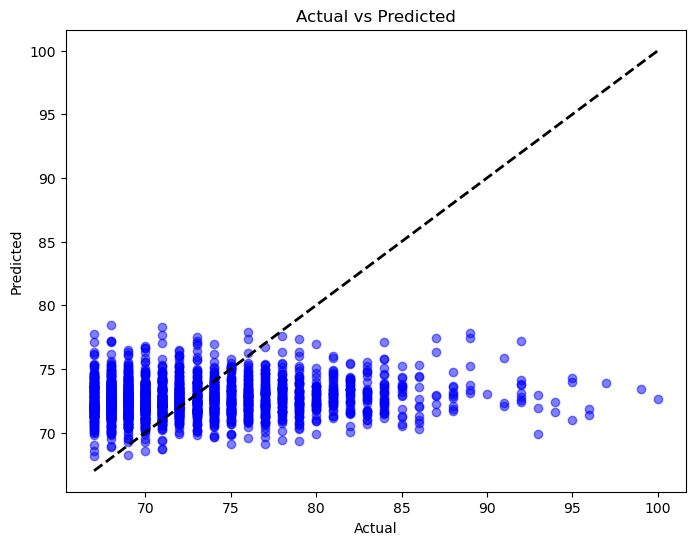

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_transformed, results_transformed, color='blue', alpha=0.5)
plt.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [54]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_transformed, results_transformed)
print("R-squared Score:", r2)

R-squared Score: -0.008626662411698405
